In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import GroupKFold

import lightgbm as lgb
print(f"LightGBM version: {lgb.__version__}")

from lofo import LOFOImportance, Dataset, plot_importance

# local modules
import sys
sys.path.append("../src")
from preproc import preprocess_data

LightGBM version: 4.5.0


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/lofo/lofo_importance.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Call the function
df_train, numerical_cols, categorical_cols = preprocess_data(
    df_train,
    scale_utility=False
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


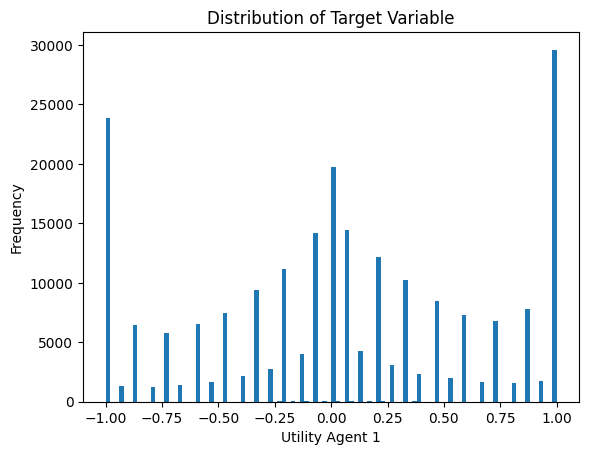

In [4]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()



***
### train model


In [5]:
# input dataset
lofo_dset = Dataset(
    df = df_train,
    target = "utility_agent1",
    features = numerical_cols + categorical_cols,
    auto_group_threshold = 0.95,
)
print("\nNumber of features:", len(lofo_dset.feature_names))

Automatically grouped features by correlation:
1 ['Asymmetric', 'AsymmetricForces', 'AsymmetricPiecesType']
2 ['PieceDirection', 'PlayersWithDirections']
3 ['Cooperation', 'Team']
4 ['PolygonShape', 'Shape', 'Tiling']
5 ['SpiralShape', 'SpiralTiling']
6 ['CircleShape', 'CircleTiling']
7 ['ShibumiStyle', 'SquarePyramidalShape']
8 ['MancalaBoard', 'MancalaStyle', 'Sow', 'SowFrequency', 'SowOriginFirst', 'SowProperties', 'SowWithEffect']
9 ['BoardStyle', 'GraphStyle', 'Vertex']
10 ['NumPlayableSites', 'NumPlayableSitesOnBoard']
11 ['NumOuterSites', 'NumPerimeterSites']
12 ['NumEdges', 'NumVertices']
13 ['NumBottomSites', 'NumTopSites']
14 ['NumLeftSites', 'NumRightSites']
15 ['Hand', 'NumContainers']
16 ['PieceRotation', 'SetRotation']
17 ['Dice', 'NumDice', 'Roll', 'RollFrequency']
18 ['OpeningContract', 'SwapOption', 'SwapPlayersDecision']
19 ['PositionalSuperko', 'Repetition']
20 ['AutoMove', 'LoopLoss', 'PathExtent', 'PathExtentEnd', 'PathExtentLoss', 'PathExtentWin', 'SetRotationFreq

In [6]:
# define the parameters
model_params = {
    'objective': "regression",
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1,
    'n_estimators': 2000,
}

# base model
lgbm_model = lgb.LGBMRegressor(**model_params)

In [7]:
num_folds = 5
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = list(gkf.split(df_train, groups=df_train[groups_col]))

In [8]:
lofo_importance = LOFOImportance(
    dataset = lofo_dset,
    scoring = 'neg_mean_squared_error',
    model = lgbm_model,
    fit_params = dict(categorical_feature=categorical_cols),
    cv = split_list,
    n_jobs = 1,   
)

In [10]:
importance_df = lofo_importance.get_importance()
importance_df.to_csv("lofo_lgbm.csv", index=False, sep=";")
importance_df

100%|██████████| 463/463 [18:20:31<00:00, 142.62s/it]  


feature  importance_mean  \
159                               AdvantageP1         0.099939   
462                 agent2 & agent2_selection         0.029482   
461                 agent1 & agent1_selection         0.027510   
131                  DecisionFactorChangeSign         0.002201   
146                     NumDiagonalDirections         0.002194   
..                                        ...              ...   
428                      NumPlayPhase & Phase        -0.001447   
282  FromToDecisionBetweenContainersFrequency        -0.001677   
33                            DurationActions        -0.001841   
384                    NumEdges & NumVertices        -0.001842   
25                              DrawFrequency        -0.002208   

     importance_std  val_imp_0  val_imp_1  val_imp_2  val_imp_3  val_imp_4  
159        0.025924   0.065982   0.121461   0.093312   0.081914   0.137024  
462        0.005482   0.032951   0.027501   0.038116   0.022357   0.026485  
461        0.004633   0.029163   0.020607   0.034785   0.027483   0.025513  
131        0.001600   0.004348   0.001211   0.002345   0.003331  -0.000231  
146        0.003422   0.000694   0.002419   0.008283   0.001737  -0.002161  
..              ...        ...        ...        ...        ...        ...  
428        0.002733  -0.000299  -0.004683   0.001659   0.000819  -0.004731  
282        0.001610  -0.000276  -0.004314   0.000035  -0.001210  -0.002621  
33         0.004120  -0.000272  -0.002545   0.004251  -0.002111  -0.008529  
384        0.002117  -0.001003  -0.002569   0.000009  -0.000011  -0.005637  
25         0.003655  -0.000139  -0.004816  -0.001452   0.002932  -0.007566  

[463 rows x 8 columns]

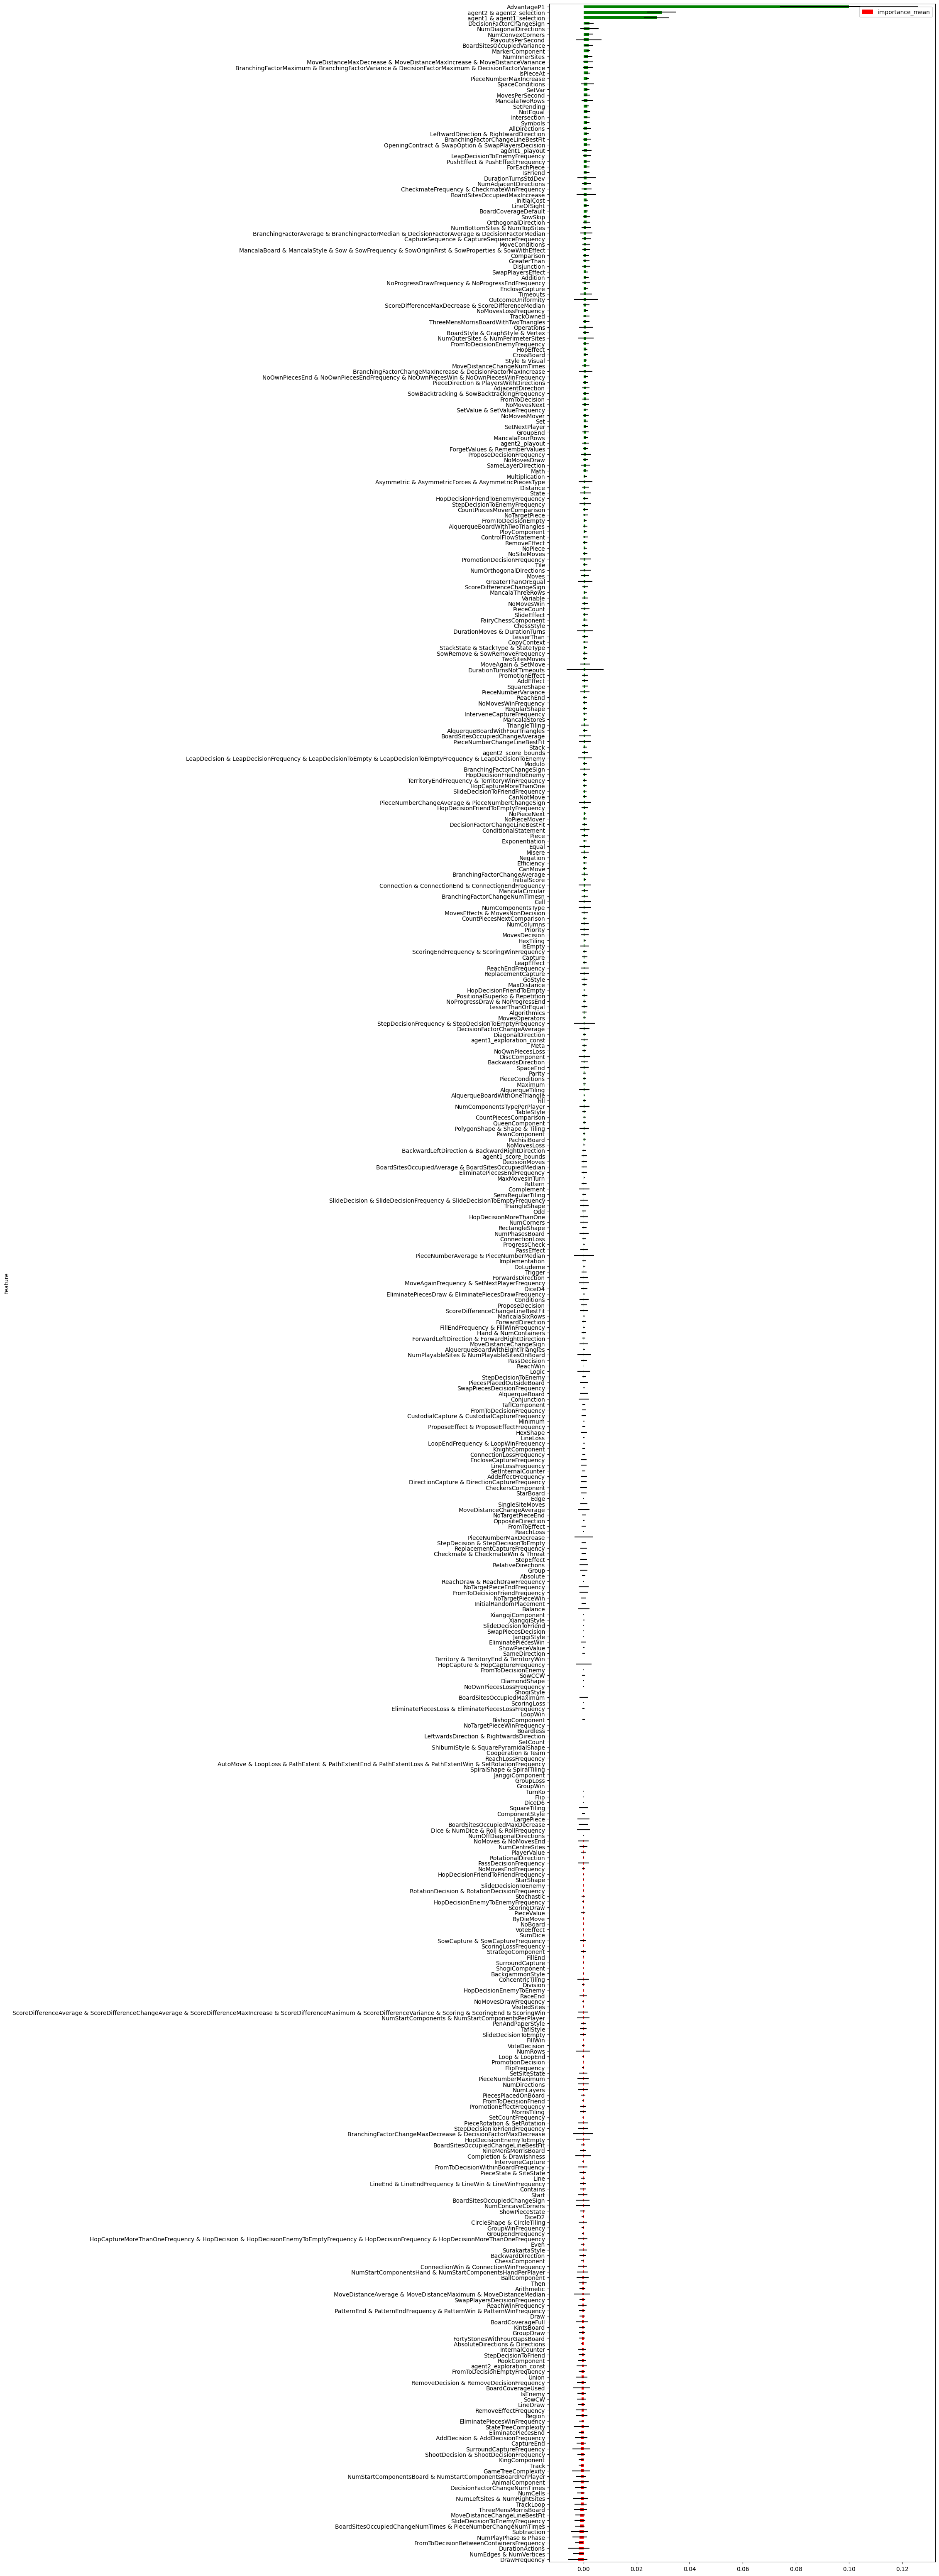

In [11]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 80))

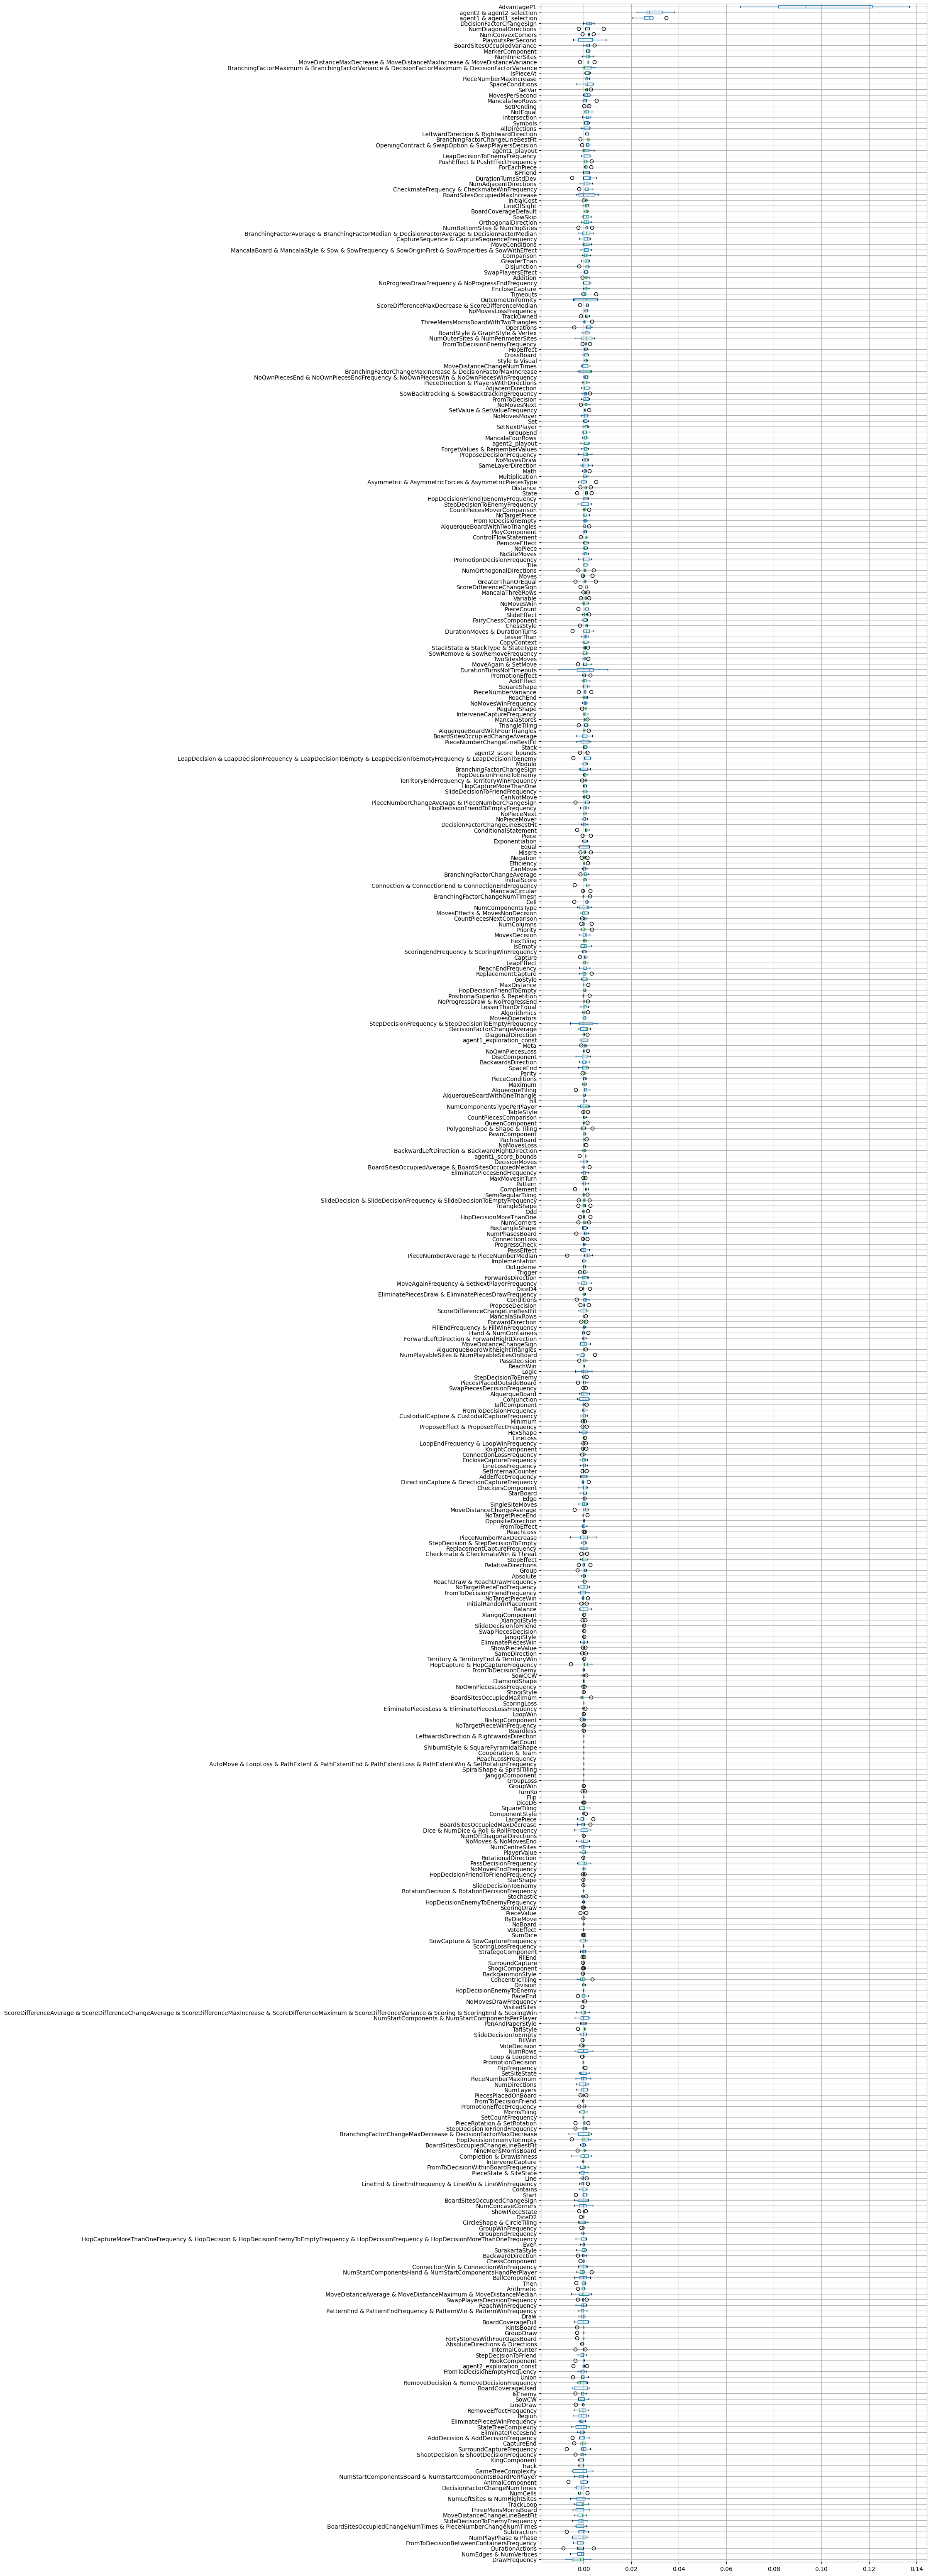

In [12]:
plot_importance(importance_df, figsize=(12, 80), kind="box")

In [13]:
importance_df.sort_values(by="importance_mean", ascending=False).tail(20)


feature  importance_mean  \
443             ShootDecision & ShootDecisionFrequency        -0.000879   
444                                      KingComponent        -0.000882   
445                                              Track        -0.000888   
446                                 GameTreeComplexity        -0.000967   
447  NumStartComponentsBoard & NumStartComponentsBo...        -0.000999   
448                                    AnimalComponent        -0.001011   
449                       DecisionFactorChangeNumTimes        -0.001031   
450                                           NumCells        -0.001068   
451                       NumLeftSites & NumRightSites        -0.001092   
452                                          TrackLoop        -0.001096   
453                               ThreeMensMorrisBoard        -0.001116   
454                      MoveDistanceChangeLineBestFit        -0.001227   
455                      SlideDecisionToEnemyFrequency        -0.001341   
456  BoardSitesOccupiedChangeNumTimes & PieceNumber...        -0.001371   
457                                        Subtraction        -0.001445   
458                               NumPlayPhase & Phase        -0.001447   
459           FromToDecisionBetweenContainersFrequency        -0.001677   
460                                    DurationActions        -0.001841   
461                             NumEdges & NumVertices        -0.001842   
462                                      DrawFrequency        -0.002208   

     importance_std  val_imp_0     val_imp_1  val_imp_2     val_imp_3  \
443        0.001473   0.000917 -3.461463e-03   0.000000 -6.276105e-04   
444        0.000914  -0.000305 -2.194208e-03   0.000035 -1.761765e-04   
445        0.001002  -0.000246 -2.325178e-03   0.000000  0.000000e+00   
446        0.003395   0.003844 -4.929217e-03   0.001283 -4.029107e-04   
447        0.001868  -0.001993 -3.948275e-03   0.001622 -2.629039e-04   
448        0.002889   0.001502 -6.417376e-03   0.001386 -3.598471e-04   
449        0.002206  -0.001001 -3.215856e-03   0.002147  5.726989e-04   
450        0.001401  -0.001460 -2.045258e-03  -0.001204  1.628593e-03   
451        0.002822   0.000491 -2.905940e-03   0.002192  4.312013e-04   
452        0.002224  -0.000512 -3.021686e-03   0.002143  3.178530e-06   
453        0.002430  -0.003243 -1.706969e-07   0.002177  1.216944e-05   
454        0.001814  -0.000464 -4.014032e-03  -0.000361  1.180656e-03   
455        0.001986   0.001330 -2.090006e-03  -0.000971 -3.353422e-04   
456        0.001801  -0.001278 -3.009434e-03   0.001128  8.286677e-07   
457        0.003169  -0.000242 -2.067187e-03   0.000438  1.895717e-03   
458        0.002733  -0.000299 -4.682603e-03   0.001659  8.190421e-04   
459        0.001610  -0.000276 -4.313976e-03   0.000035 -1.209758e-03   
460        0.004120  -0.000272 -2.544633e-03   0.004251 -2.111056e-03   
461        0.002117  -0.001003 -2.569261e-03   0.000009 -1.120887e-05   
462        0.003655  -0.000139 -4.815848e-03  -0.001452  2.932298e-03   

     val_imp_4  
443  -0.001225  
444  -0.001767  
445  -0.001871  
446  -0.004628  
447  -0.000413  
448  -0.001167  
449  -0.003656  
450  -0.002258  
451  -0.005666  
452  -0.004092  
453  -0.004526  
454  -0.002476  
455  -0.004639  
456  -0.003695  
457  -0.007249  
458  -0.004731  
459  -0.002621  
460  -0.008529  
461  -0.005637  
462  -0.007566

In [14]:
# features to drop
features_to_drop =(
    importance_df
    .sort_values(by="importance_mean", ascending=False)
    .tail(20)
    .feature
).to_list()

features_to_drop = [
    f.strip() for feat in features_to_drop for f in feat.split("&")
]
features_to_drop


['ShootDecision',
 'ShootDecisionFrequency',
 'KingComponent',
 'Track',
 'GameTreeComplexity',
 'NumStartComponentsBoard',
 'NumStartComponentsBoardPerPlayer',
 'AnimalComponent',
 'DecisionFactorChangeNumTimes',
 'NumCells',
 'NumLeftSites',
 'NumRightSites',
 'TrackLoop',
 'ThreeMensMorrisBoard',
 'MoveDistanceChangeLineBestFit',
 'SlideDecisionToEnemyFrequency',
 'BoardSitesOccupiedChangeNumTimes',
 'PieceNumberChangeNumTimes',
 'Subtraction',
 'NumPlayPhase',
 'Phase',
 'FromToDecisionBetweenContainersFrequency',
 'DurationActions',
 'NumEdges',
 'NumVertices',
 'DrawFrequency']

***